# Hierarchical Bayesian Photo-z

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import time
import scipy.stats
import seaborn as sns

import matplotlib.patches as patches

from astropy.table import Table, join
from multiprocessing import Process, Queue

sns.set()

**Changes in response to author feedback:**
 - Treat generated t and z values as discrete, effectively tying them to the bin centers. This means dropping the `z` and `t` real-valued columns from the galaxies table, reverting to `nz=nt=50`, and updating `assign_redshifts` to work directly with bin indices.
 - Do sampling using only the filled (z,t) bins, which are on the diagonal or the first off diagonal. The new section **Sparsification** converts between (z,t) 2D indices and the flattened 1D sparse index.
 - Update `demo_sampler` to work with sparse 1D indices. A 25K chain now takes 4m20s instead of 70m!
 - Generate 4 chains of 2.5K samples using the prior only.
 - Update `compare_distributions` to work sparse 1D indices.
 - Update the GR convergence test to use the dz metric of eqn (37).
 - Remove unused / scratch cells.

### Introduction
This notebook goes through how to reproduce the plots in [this](https://arxiv.org/pdf/1807.11873.pdf) paper by Sánchez and Bernstein. The paper uses a Hierarchical Bayesian framework to estimate photometric redshifts. 

(write more later)

## General Utilities

This section has utilities for implementing the general infererence scheme described in Sections 2-4 of the paper. The following sections use these utilities to reproduce the demonstration in Section 5.

In [3]:
import time, sys
import IPython.display

class ProgressBar(object):
    """Replace existing contents of the current output cell with a progress bar.
    """
    def __init__(self, maxval=1., label='Progress', width=40):
        self.maxval = maxval
        self.label = label
        self.width = width
        self.start_at = time.time()
        self.update(0.)
    def update(self, value):
        elapsed = int(round(time.time() - self.start_at))
        mins = elapsed // 60
        secs = elapsed % 60
        timing = '{mins}m{secs:02d}s'.format(mins=mins, secs=secs)
        frac = value / self.maxval
        ndone = int(round(frac * self.width))
        bar = '#' * ndone + '-' * (self.width - ndone)
        text = '{label}: [{bar}]{pct:5.1f}% {timing}'.format(
            label=self.label, bar=bar, pct=100 * frac, timing=timing)
        IPython.display.clear_output(wait=True)
        print(text)

In [4]:
def dirichlet(rng, counts, alpha_offset=1.):
    """Draw a single sample from a Dirichlet distribution.

    Any bins with zero count (after adding the offset) are effectively ignored
    and have corresponding probabilities zeroed.

    Parameters
    ----------
    rng : numpy random state
        Reproducible random state.
    counts : array
        1D array of integer bin counts.
    alpha_offset : float
        Used to calculate the Dirichlet concentration parameters from the prior
        plus previous iteration bin counts. A value of 0 results in samples with a
        posterior mean of nbin / ntot for each bin, but will always return 0
        when nbin=0.  A value of 1 results in samples with a posterior mode of
        nbin / ntot for each bin, and generates random f > 0 when nbin=0 with
        a corresponding decrease in f for bins with nbin>0 in order to satisify
        sum(f) = 1.

    Returns
    -------
    array
        1D array of probabilities associated with each bin, which sum to one.
    """
    counts = np.asarray(counts)
    alpha = counts + alpha_offset
    nonzero = alpha != 0
    if np.any(nonzero):
        probs = np.zeros_like(alpha)
        probs[nonzero] = rng.dirichlet(alpha[nonzero], size=1)[0]
    else:
        probs = rng.dirichlet(alpha, size=1)[0]
    return probs

In [5]:
def categorical(rng, probs):
    """Sample from one or more categorical distributions.
    
    Uses a vectorized argmax implementation to sample from the
    inverse CDF, based on the timing tests in the Gibbs_studies notebook.
    
    Parameters
    ----------
    rng : numpy random state
        Reproducible random state.
    probs : array
        Array of probabilities to use for each category with shape (...,ncat).
        Will be normalized, so each value only needs to be non-negative.
    
    Returns
    -------
    array or int
        If probs is 1D, return a single int for the sampled category. Otherwise,
        return an array of shape (...) where probs has shape (...,ncat). Each
        category sample is an integer in the range [0, ncat).
    """
    probs = np.asarray(probs)
    # How many categories are there?
    ncat = probs.shape[-1]
    # Normalize along last axis.
    probs /= probs.sum(axis=-1, keepdims=True)
    # Calculate CDFs for each sample.
    cdfs = probs.cumsum(axis=-1)
    # Generate a uniform deviate for each sample.
    u = rng.uniform(size=probs.shape[:-1] + (1,)).astype(probs.dtype)
    # Find the index of the first CDF entry that is larger than the uniform deviate.
    return np.argmax(cdfs > u, axis=-1)

In [6]:
class HBMSampler(object):
    
    def __init__(self, nz, nt, prior_zt, likelihood, alpha_offset=0.001, seed=123):
        """
        """
        self.nz = nz
        self.nt = nt
        self.alpha_offset = alpha_offset
        self.rng = np.random.RandomState(seed)
        if prior_zt is not None:
            self.prior_counts = np.bincount(prior_zt, minlength=nz * nt)
        else:
            self.prior_counts = np.zeros(nz * nt, int)
        

In [7]:
def gibbs_step1(nzt, previous_zt=None, prior_zt=None, rng=None, alpha_offset=1.):
    """Perform the first step of a single Gibbs sample.
    
    Draw a sample from the conditional posterior P(f | N) where N represents the
    combined flattened histogram counts for the previous iteration and prior and
    f are the per-bin probabilities that sum to one.

    Parameters
    ----------
    nzt : int
        Total number of (flattened) redshift-phenotype bins.
    previous_zt : array or None
        1D array of redshift-phenotype bin indices from the previous Gibbs sample,
        or None if this is the first sample.
    prior_zt : array or None
        1D array of redshift-phenotype bin indices for the prior sample to use,
        or None to use a non-informative prior.
    rng : numpy random state or None
        Random state to use for reproducible random numbers.
    alpha_offset : float
        Used to calculate the Dirichlet concentration parameters from the prior
        plus previous redshift-phenotype bin counts. A value of 0 results in samples with a
        posterior mean of nbin / ntot for each bin, but will always return 0
        when nbin=0.  A value of 1 results in samples with a posterior mode of
        nbin / ntot for each bin, and generates random f > 0 when nbin=0 with
        a corresponding decrease in f for bins with nbin>0 in order to satisify
        sum(f) = 1.
    
    Returns
    -------
    tuple
        Tuple (probs_zt, counts_zt) of 1D arrays of length nzt, where probs_zt gives
        the probabilities associated with each redshift-phenotype bin, which sum to one, and
        counts_zt gives the corresponding integer bin counts.
    """
    counts = np.zeros(nzt, int)
    # Histogram the previous iteration.
    if previous_zt is not None:
        counts += np.bincount(previous_zt, minlength=nzt)
    if prior_zt is not None:
        # Could cache these counts for the usual case where prior_zt is always the same.
        counts += np.bincount(prior_zt, minlength=nzt)
    # Calculate the Dirichlet concentration parameters from the bin counts.
    alpha = counts + alpha_offset
    # Return a single Dirichlet sample.
    rng = rng or np.random.RandomState()
    return dirichlet(rng, counts, alpha_offset), counts

In [8]:
def gibbs_step2(probs_zt, likelihood, rng=None):
    """Perform the second step of a single Gibbs sample.
    
    TODO:
    - add bias to the (1 + delta) contribution to probs.
    - use ngal subset chunks to limit size of the 3D probs array.
    
    Parameters
    ----------
    probs_zt : array
        1D array of redshift-phenotype bin probabilities with length nzt that sum to one.
        Normally obtained as the output of :func:`gibbs_step1`.
    likelihood : array
        2D array of shape (ngal, nzt) of (relative) likelihoods for each galaxy's
        observed sky position and features for each possible redshift-phenotype bin.
    rng : numpy random state or None
        Random state to use for reproducible random numbers.
        
    Returns
    -------
    array
        1D array of length ngal giving the assigned redshift-phenotype bin
        index for each galaxy after this step.
    """
    rng = rng or np.random.RandomState()
    # Calculate probs for all samples in a 2D array of shape (ngal, nzt).
    probs = likelihood * probs_zt
    # Sample a category [0, nzt) for each galaxy.
    return categorical(rng, probs)

Calculate the Gelman-Rubin statistic (original paper [here](https://projecteuclid.org/euclid.ss/1177011136) with some recent developments [here](https://arxiv.org/abs/1812.09384)).

In [9]:
def gr_metric(values, nburnin=0):
    """Calculate the Gelman-Rubin convergence statistic.
    
    The original paper is at https://projecteuclid.org/euclid.ss/1177011136
    
    Parameters
    ----------
    values : array
        2D array of shape (nchain, nsample) containing a single scalar value per Gibbs sample
        from independent chains.
    nburnin : int
        Number of initial samples to drop from each chain before calculating the statistic.
        
    Returns
    -------
    float
        The value o the Gelman-Rubin convergence statistic.  Values close to 1 indicate
        good convergence.
    """
    nchain, nsample = values.shape
    # Pick out the scalar value to use for each sample.
    X = values[:, nburnin:]
    n = nsample - nburnin
    # Calculate the mean and variance of X within each independent chain.
    chain_mean = np.mean(X, axis=1)  # Xbar_i
    chain_var = np.var(X, axis=1)    # s_i^2
    # Calculate the (unweighted) average of chain means and variances.
    mu_all = np.mean(chain_mean)     # muhat
    var_all = np.mean(chain_var)     # s^2
    # Calculate the variance of chain means.
    var_mean = np.var(chain_mean)    # B/n
    # The expectation value for var_all is n/(n - 1) (var_true - var_mean).
    # If the chains are converged, we expect var_mean = var_true / n,
    # in which case the expectation of var_all is var_true.
    # If the chains are not converged, var_mean is generally larger than
    # var_true / n, which biases var_all to a smaller value.
    # Estimate the true variance from var_all as:
    var_est = (n - 1) / n * var_all + var_mean
    # Compare var_est and var_all.
    return np.sqrt(var_est / var_all)

## Demonstration

#### Set up global variables:

In [10]:
N = 100000 ## number of galaxies in the photometric sample
nz = 50 ## number of redshift bins
nt = 50 ## number of type bins
nx = 1024 ## number of pixels in each dimension of density field
a = 1.5 ## model parameter for type distribution (see Eq. 34)
t0 = 0.3 ## model parameter for type distribution (see Eq. 34)
sig_F = 0.02 ## scale for feature likelihood
seed = 11
rng = np.random.RandomState(seed)

#### Define functions we'll be using throughout the notebook:

In [11]:
def setup_bins(nz, nt):
    
    '''
    Parameters:
    -----------
    
    nz: Number of redshift bins.
    
    nt: Number of type bins.
    
    Returns:
    --------
    
    z_bins: np.array() containing the redshift bin edges.
    
    z_mdpt: np.array() containing the redshift bin centers.
    
    t_bins: np.array() containing the type bin edges.
    
    t_mdpt: np.array() containing the type bin centers.
    
    '''
    
    z_bins = np.linspace(0, 1, nz+1)
    z_mdpt = (z_bins[1:] + z_bins[:-1]) / 2
    t_bins = np.linspace(0, 1, nt+1)
    t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2
    
    return(z_bins, z_mdpt, t_bins, t_mdpt)

## Inverse transform sample
def sample(uniform, x_interp, size, rng):
    
    '''
    Parameters:
    -----------
    
    uniform:  Array of values sampled from a uniform distribution between [0,1] 
              over which the x_interp is interpolated over.
              
    x_interp: The domain of the CDF that has been interpolated over uniform.
    
    size:     Number of samples to be drawn.
    
    rng:      Instance of np.random.RandomState().
    
    Returns:
    --------
    
    Sampled values over the domain. 
    
    '''
    
    ## uniform is proxy for the CDF
    rndm = rng.uniform(size=size)
    idx = [(np.abs(uniform - rndm[ii])).argmin() for ii in range(size)]
    return(x_interp[idx])


# Discrete implementation of eqn (35) using bin indices.
def assign_redshifts(t_bin, rng, offset=1):
    u = rng.uniform(size=len(t_bin))
    # dt will be 0 with 60% prob, +1 with 20% prob and -1 with 20% prob.
    dt = 1 * (u > 0.8) - 1 * (u < 0.2)
    # Apply dt offets
    z_bin = np.array(t_bin) + dt
    # Clamp z_bin values, effectively changing the probs in the first
    # and last bin to 80% / 20%.
    z_bin[z_bin == -1] = 0
    z_bin[z_bin == nz] = nz - 1
    return z_bin

## Feature distribution
def feature_likelihood(t, scale, rng):
    
    '''Sample a feature value for each galaxy from a normal 
    distribution centered on the galaxy's type.
    
    Parameters:
    -----------
    
    t:     An array of type values 
    scale: The standard deviation of the flux distribution.
    rng:   Instance of np.random.RandomState()
    
    Returns:
    --------
    
    Feature values for each galaxy in the sample. 
    
    '''
    return(scipy.stats.norm.rvs(loc=t, scale=scale, random_state=rng))

## Delta field
def fftIndgen(n):
    
    '''Generate grid of k values over which to calculate 
       power spectrum.
    
    Parameters:
    -----------
    
    n: Dimension of delta field.
    
    Returns:
    --------
    
    Grid of k values from -(n/2 +1) to n/2 over which to calculate the power spectrum.
    
    '''
    a = range(0, int(n/2)+1)
    b = range(1, int(n/2))
    b = reversed(b)
    a = [i for i in a]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(rng, Pk = lambda k : k**-3.0, size = 1024):

    '''
    Generate a Gaussian random field.
    
    Parameters:
    -----------
    
    Pk: Function to compute the power spectrum.
    
    size: Dimension of delta field. 
    
    Returns:
    --------
    
    Amplitude of delta field in position (ra, dec) space. 
    '''
    kvec = np.asarray(fftIndgen(size))
    kgrid = np.sqrt(kvec.reshape(-1, 1) ** 2 + kvec ** 2)
    amplitude = np.zeros_like(kgrid)
    amplitude[kgrid != 0] = np.sqrt(Pk(kgrid[kgrid != 0]))
    noise = np.fft.fft2(rng.normal(size = (size, size)))
    return np.fft.ifft2(noise * amplitude)

def delta_field(nx, nz, rms=2.5, seed=123):
    
    '''
    Generate a Gaussian random field for each redshift slice. 
    
    Parameters:
    -----------
    
    nx: Number of pixels in x-direction of delta field (ra).
    nz: Number of pixels in y-direction of delta field (dec).
    rms: Variance of GRF.
    
    Returns:
    --------
    
    An array of shape (nx, nx, nz) containing the density of 
    galaxies in each redshift slice. 
    '''
    delta = np.empty((nz,nx,nx))
    rng = np.random.RandomState(seed)
    Pk = lambda k: k**-3.0
    for i in range(nz):
        z_slice = gaussian_random_field(rng, Pk, size=nx).real
        ## set variance = 2.5
        delta[i] = (z_slice / np.std(z_slice)) * rms
    return(delta)

def get_positions(rho, z_indices, nx, nz, N, rng):
    
    '''
    Get (ra,dec) position for each galaxy.
    
    Parameters:
    -----------
    
    rho: The over-density field (as defined in Eq. 33)
    
    z_indices: The redshift bin that a galaxy falls into. 
    
    nx: 
    
    nz: 
    
    N:
    
    rng:
    
    Returns:
    --------
    
    Ra,Dec positions for each galaxy.
    
    '''
    
    rho_flat = rho.reshape(nz, nx*nx)
    cdf = np.cumsum(rho_flat, axis=1)
    cdf /= cdf[:, -1].reshape(-1, 1)

    theta_bin = np.empty(N, dtype=int)

    for i in range(nz):
        galaxies_index = np.argwhere(z_indices == i).reshape(-1)
        num_galaxies = len(galaxies_index)
        if num_galaxies == 0:
            continue
        u = rng.uniform(size=num_galaxies)
        indices = np.searchsorted(cdf[i], u)
        theta_bin[galaxies_index] = indices
    
    return theta_bin

Use the options below to control whether the sample is reloaded or generated and saved.  Use `reload=False` and `save=True` if this is the first time running this notebook.

In [12]:
data_dir = '../data/bernstein_data/'
reload = True
save = False

#### Setup redshift and type bins and midpoints:

In [13]:
z_bins, z_mdpt, t_bins, t_mdpt = setup_bins(nz=nz, nt=nt)

In [14]:
if reload:
    rho = np.load(data_dir+'rho_seed11.npy')
    delta = rho - 1
    galaxies = Table.read(data_dir+'galaxies_seed11.fits', format='fits')

#### Create table to store initial galaxy values:

In [15]:
if not reload:
    col_names = ['F', 'z_bin', 't_bin', 'theta_bin']
    galaxies = Table(data=np.full((N,len(col_names)), 0), 
                     names=(col_names))

### 1. Sample types

In [16]:
t_grid = np.linspace(0., 1., 201)
pt_grid = t_grid ** a * np.exp(-(t_grid / t0) ** a)
if not reload:
    pt_cdf = np.cumsum(pt_grid)
    pt_cdf /= pt_cdf[-1]
    t_val = np.interp(rng.uniform(size=N), pt_cdf, t_grid)
    galaxies['t_bin'] = np.digitize(t_val, t_bins) - 1

### 2. Sample redshifts

In [17]:
if not reload:
    galaxies['z_bin'] = assign_redshifts(galaxies['t_bin'], rng)

### 3. Sample features

In [18]:
if not reload:
    galaxies['F'] = feature_likelihood(t_mdpt[galaxies['t_bin']], scale=sig_F, rng=rng)

### 4. Sample positions

In [19]:
if not reload:
    ## First generate the density field
    delta = delta_field(nx, nz)
    rho = np.maximum(0, delta + 1)
    galaxies['theta_bin'] = get_positions(rho, galaxies['z_bin'], nx, nz, N, rng)

Save the generated sample so it can be reloaded next time:

In [20]:
if save:
    galaxies.write(data_dir + 'galaxies_seed{}.fits'.format(seed), format='fits', overwrite=True)
    np.save(data_dir + 'rho_seed{}'.format(seed), rho)

#### Let's make sure everything looks OK...

In [21]:
fs = 14

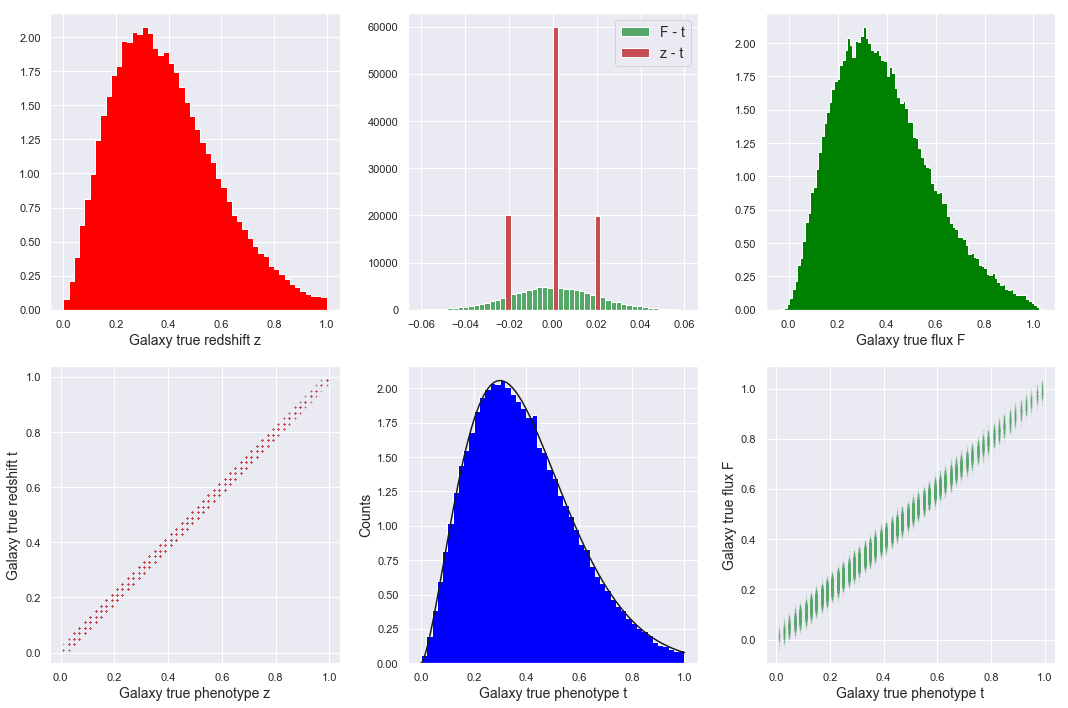

In [22]:
fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()

axs[0].hist(z_mdpt[galaxies['z_bin']], bins=z_bins, color='red', histtype='stepfilled', density=True)
axs[0].set_xlabel('Galaxy true redshift z', fontsize=fs)

_, bins, _ = axs[1].hist(galaxies['F'] - t_mdpt[galaxies['t_bin']], color='g',  bins=50,
                         range=(-3 * sig_F, +3 * sig_F), label='F - t')
axs[1].hist(z_mdpt[galaxies['z_bin']] - t_mdpt[galaxies['t_bin']], bins=bins, color='r', label='z - t')
axs[1].legend(fontsize=fs)

axs[2].hist(galaxies['F'], bins=100, color='green', histtype='stepfilled', density=True)
axs[2].set_xlabel('Galaxy true flux F', fontsize=fs)

axs[3].plot(t_mdpt[galaxies['t_bin']], z_mdpt[galaxies['z_bin']], 'r.', ms=1, alpha=0.01)
axs[3].set_xlabel('Galaxy true phenotype z', fontsize=fs)
axs[3].set_ylabel('Galaxy true redshift t', fontsize=fs)

axs[4].hist(t_mdpt[galaxies['t_bin']], bins=t_bins, color='blue', histtype='stepfilled', density=True)
axs[4].plot(t_grid, pt_grid / pt_grid.sum() / np.gradient(t_grid), 'k-')
axs[4].set_ylabel('Counts', fontsize=fs)
axs[4].set_xlabel('Galaxy true phenotype t', fontsize=fs)

axs[5].plot(t_mdpt[galaxies['t_bin']], galaxies['F'], 'g.', ms=1, alpha=0.1)
axs[5].set_xlabel('Galaxy true phenotype t', fontsize=fs)
axs[5].set_ylabel('Galaxy true flux F', fontsize=fs)

plt.tight_layout()
plt.show()

### Reproduction of Figure 2

In [23]:
def figure2(frac=0.05, theta_x0=nx // 4, theta_y0=nx // 2):

    fig, axs = plt.subplots(5, 10, figsize=(16, 8))
    axs = axs.ravel()

    unique, counts = np.unique(galaxies['z_bin'], return_counts=True)
    ## Only plot a random 5% subsample of 
    n_subsamples = np.round(counts * frac).astype(int)

    theta_bin = galaxies['theta_bin'].data
    theta_y = theta_bin // nx
    theta_x = theta_bin % nx
    
    for i in range(nz):
        select = galaxies['z_bin'] == i
        axs[i].imshow(rho[i], origin='lower', alpha=0.5, cmap='Reds', vmin=0, vmax=10)
        axs[i].plot(theta_x[select][:n_subsamples[i]], theta_y[select][:n_subsamples[i]], 'k.', ms=2)
        axs[i].scatter(theta_x0, theta_y0, marker='o', s=150, lw=2, edgecolors='g', facecolors='none')
        axs[i].axis('off')

    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()
    
    fig = plt.figure(figsize=(16, 2))
    plt.hist(z_mdpt, bins=z_bins, weights=rho[:, theta_y0, theta_x0], histtype='stepfilled', alpha=0.5, color='g')
    plt.xlim(z_bins[0], z_bins[-1])
    plt.ylabel('$1 + \\delta(z)$')

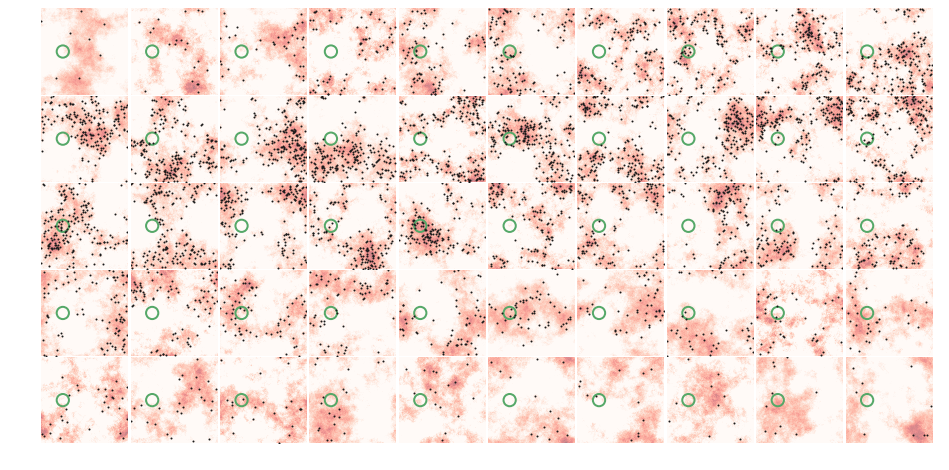

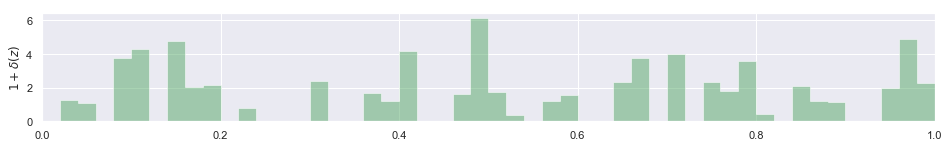

In [24]:
figure2()

**Now that we've generated our photometric data set, we will use this to reproduce the figures in section 5.1**

The results of the fiducial case use 8 x 10^4 galaxies from the initial simulation as our **photometric** sample (for which we know only F, theta), and a separate random **spectroscopic** sample of 1k galaxies as my prior (for which we z,t in addition to F,theta).

In [25]:
n_photo = 80000
n_spectro = 1000

Since the generated galaxies are already random, we just take the first 80K as the fiducial sample and the next 1K as the prior sample:

In [26]:
if reload:
    photo_data = Table.read(data_dir + 'photo_data_seed{}.fits'.format(seed))
    spectro_data = Table.read(data_dir + 'spectro_data_seed{}.fits'.format(seed))

In [27]:
if not reload:
    photo_data = galaxies[:n_photo]
    spectro_data = galaxies[n_photo:n_photo + n_spectro]

In [28]:
if save:
    photo_data.write(data_dir + 'photo_data_seed{}.fits'.format(seed), format='fits', overwrite=True)
    spectro_data.write(data_dir + 'spectro_data_seed{}.fits'.format(seed), format='fits', overwrite=True)

### Sparsification

Galaxies are currently binned in a 2D space of shape (nz, nt) but most of these bins are empty. The only non-empty bins are on the diagonal or the first off diagonals:

In [29]:
assert nt == nz
filled = np.array([[1 if abs(i - j) <= 1 else 0 for i in range(nt)] for j in range(nz)])
print(filled[:5, :5])

[[1 1 0 0 0]
 [1 1 1 0 0]
 [0 1 1 1 0]
 [0 0 1 1 1]
 [0 0 0 1 1]]


Build a 2D array such that `k=flat_index[iz, it]` is a flattened index in the range [0, 3 * nt - 2), or -1 for unfilled bins:

In [30]:
nsparse = 3 * nt - 2
assert np.count_nonzero(filled) == nsparse
flat_index = np.full((nz, nt), -1)
flat_index[filled > 0] = np.arange(nsparse)
print(flat_index[:5, :5])

[[ 0  1 -1 -1 -1]
 [ 2  3  4 -1 -1]
 [-1  5  6  7 -1]
 [-1 -1  8  9 10]
 [-1 -1 -1 11 12]]


Build 1D arrays such that `unflat_z[k]` and `unflat_t[k]` convert a flat index k back to the original iz and it:

In [31]:
unflat_z, unflat_t = np.where(filled)

Check that a round trip through `flat_index` then `unflat_t` and `unflat_k` returns to the same indices:

In [32]:
for iz in range(nz):
    for it in range(nt):
        if filled[iz, it]:
            k = flat_index[iz, it]
            assert iz == unflat_z[k]
            assert it == unflat_t[k]

### Reproduce the Demonstration Chains of Section 5

I think `alpha_offset=1` is generally a better choice, but the authors used 0.

In [33]:
def demo_sampler(photo_data, spectro_data, n_cycles=2500, zmax=1.0, alpha_offset=0.,
                 onlyprior=False, seed=123, save=None):
    
    rng = np.random.RandomState(seed)
    
    # Use true delta field instead of an estimator based on tracers.
    delta_est = np.transpose(delta.reshape(nz, -1))
    # Clip so that 1 + delta >= 0.
    delta_est = np.maximum(-1, delta_est)
    # Zero out slices with z > zmax.
    delta_est[:, z_mdpt > zmax] = 0.
    
    # Calculate the sparse bin index for each spectroscopic galaxy.
    prior_zt = flat_index[spectro_data['z_bin'].data, spectro_data['t_bin'].data]
    
    if onlyprior:
        # Use a flat likelihood so we are only sampling from the prior.
        likelihood = np.ones(shape=(len(photo_data), nsparse), dtype=np.float32)
        
    else:
        # Calculate the likelihood of each photometric galaxy's features for each t bin.
        F = photo_data['F'].data.reshape(-1, 1)
        feature_likelihood = scipy.stats.norm.pdf(F, loc=t_mdpt, scale=sig_F)
        # Calculate the likelihood of each photometric galaxy's sky position for each z bin.
        theta = photo_data['theta_bin'].data
        theta_likelihood = 1 + delta_est[theta]
        theta_likelihood /= theta_likelihood.sum(axis=-1, keepdims=True)
        # Combine the feature and sky position likelihoods, which are fixed during sampling.
        likelihood = feature_likelihood[:, unflat_t] * theta_likelihood[:, unflat_z]
        # Convert to float32.
        likelihood = likelihood.astype(np.float32)
    
    previous_zt = None
    samples = np.empty((n_cycles, len(photo_data)), np.uint16)
    progress = ProgressBar(label='Gibbs Sampler', maxval=n_cycles)
    for cycle in range(n_cycles):
        probs_zt, counts_zt = gibbs_step1(nsparse, previous_zt, prior_zt, rng, alpha_offset)
        previous_zt = samples[cycle] = gibbs_step2(probs_zt.astype(np.float32), likelihood, rng)
        progress.update(cycle + 1)
    
    if save:
        print('Saving samples to {}'.format(save))
        np.save(save, samples)
        
    return samples

Run a small benchmarking test with 100 samples. A chain with 2500 samples takes 4-5 mins to run on my laptop.

In [34]:
samples = demo_sampler(photo_data, spectro_data, n_cycles=100)

Gibbs Sampler: [########################################]100.0% 0m10s


Generate chains using only features F in the likelihood (zmax=0):

In [35]:
#samples_noz_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, zmax=0., save='noz_1')
#samples_noz_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, zmax=0., save='noz_2')
#samples_noz_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, zmax=0., save='noz_3')
#samples_noz_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, zmax=0., save='noz_4')

Generate chains using full clustering information (zmax=1):

In [36]:
#samples_fullz_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, save='fullz_1')
#samples_fullz_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, save='fullz_2')
#samples_fullz_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, save='fullz_3')
#samples_fullz_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, save='fullz_4')

Generate chains using partial clustering information (zmax=0.5):

In [37]:
#samples_halfz_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, zmax=0.5, save='halfz_1')
#samples_halfz_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, zmax=0.5, save='halfz_2')
#samples_halfz_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, zmax=0.5, save='halfz_3')
#samples_halfz_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, zmax=0.5, save='halfz_4')

Generate chains sampled using only the prior:

In [38]:
#samples_prior_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, onlyprior=True, save='prior_1')
#samples_prior_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, onlyprior=True, save='prior_2')
#samples_prior_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, onlyprior=True, save='prior_3')
#samples_prior_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, onlyprior=True, save='prior_4')

The generated outputs are available at NERSC in `/global/homes/d/dkirkby/HBM/demo/` as 3 tarfiles. Extract the four chains from each using:
```
tar zxf fullz.tgz
tar zxf halfz.tgz
tar zxf noz.tgz
```
The resulting 12 uncompressed numpy files are 381Mb each, and contain an array of shape (2500, 80000) of uint16 values that encode the (z, t) bin for each (sample, galaxy) as `flat_index[iz,it]`.

Load a set of chains using:

In [39]:
def load_chains(name, seeds=(1, 2, 3, 4)):
    shape = None
    for k, seed in enumerate(seeds):
        bins = np.load('{}_{}.npy'.format(name, seed))
        if shape is None:
            shape = bins.shape
            combined = np.empty((len(seeds),) + shape, bins.dtype)
        else:
            assert bins.shape == shape, 'Expected all chains to have the same shape.'
        combined[k] = bins
    return combined

In [40]:
#data_path = '../data/bernstein_data/dkirkby_hbm_data/'
data_path='./'

In [41]:
fullz = load_chains(data_path + 'fullz')
halfz = load_chains(data_path + 'halfz')
noz = load_chains(data_path + 'noz')
prior = load_chains(data_path + 'prior')

#### Sample  Metric

Calculate the average of the posterior redshifts for a sample and compare with the true average redshift, as in eqn (37):

In [42]:
def dzmetric(samples, truth):
    ztrue = z_mdpt[truth['z_bin']].mean()
    nchain, nsample, ngal = samples.shape
    zsample = np.empty((nchain, nsample))
    for i in range(nchain):
        for j in range(nsample):
            z_bin = unflat_z[samples[i, j]]
            zsample[i, j] = z_mdpt[z_bin].mean()
    return zsample - ztrue

In [43]:
dz_fullz = dzmetric(fullz, photo_data)
dz_halfz = dzmetric(halfz, photo_data)
dz_noz = dzmetric(noz, photo_data)
dz_prior = dzmetric(prior, photo_data)

#### Convergence Tests

Check that the 4 chains for each approach are converged using the Gelman-Rubin statistic applied to our sample metric. Values of R - 1 close to 0 indicate good convergence. The authors put a cut at 0.03.

In [44]:
for values in dz_fullz, dz_halfz, dz_noz, dz_prior:
    print('R - 1 = {:.4f}'.format(gr_metric(values) - 1))

R - 1 = 0.0003
R - 1 = 0.0117
R - 1 = 0.0146
R - 1 = 0.0128


#### Figures 3 and 6

Write a function that compares the sampler output with the true redshift and type distributions:

In [45]:
def compare_distributions(photo_truth, spectro_truth, samples):
    
    fig, axs = plt.subplots(1,2, figsize=(15,6))
    axs = axs.ravel()
    
    # Plot the true distributions of z and t for both samples.
    axs[0].hist(z_mdpt[photo_truth['z_bin']], bins=z_bins, alpha=0.3, histtype='stepfilled', density=True, label='Photo')
    axs[0].hist(z_mdpt[spectro_truth['z_bin']], bins=z_bins, lw=2, histtype='step', density=True, label='Spectro')
    axs[1].hist(t_mdpt[photo_truth['t_bin']], bins=t_bins, alpha=0.3, histtype='stepfilled', density=True, label='Photo')
    axs[1].hist(t_mdpt[spectro_truth['t_bin']], bins=t_bins, lw=2, histtype='step', density=True, label='Spectro')
    
    nsamples, ngal = samples.shape
    z_norm = ngal * np.diff(z_bins)
    t_norm = ngal * np.diff(t_bins)
    
    z_pdf = np.empty((nsamples, nz))
    t_pdf = np.empty((nsamples, nt))
    for i, sample in enumerate(samples):
        z_pdf[i] = np.bincount(unflat_z[sample], minlength=nz) / z_norm
        t_pdf[i] = np.bincount(unflat_t[sample], minlength=nt) / t_norm
        
    def vplot(ax, x, y, c='k'):
        parts = ax.violinplot(x, y, widths=0.01, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(c)
            pc.set_edgecolor(c)
            pc.set_alpha(0.8)
            
    vplot(axs[0], z_pdf, z_mdpt)
    vplot(axs[1], t_pdf, t_mdpt)

    axs[0].set_ylabel('Density', fontsize=fs)
    axs[0].set_xlabel('Redshift z', fontsize=fs)
    axs[1].set_xlabel('Phenotype t', fontsize=fs)
    
    axs[0].set_xlim(z_bins[0], z_bins[-1])
    axs[1].set_xlim(t_bins[0], t_bins[-1])
    axs[0].set_ylim(0., 3.)
    axs[1].set_ylim(0., 3.)
    
    axs[0].legend(fontsize=fs)
    axs[1].legend(fontsize=fs)
    
    plt.tight_layout()
    plt.show()

Split Figure 3 into separate plots for F (noz) and F+delta (fullz):

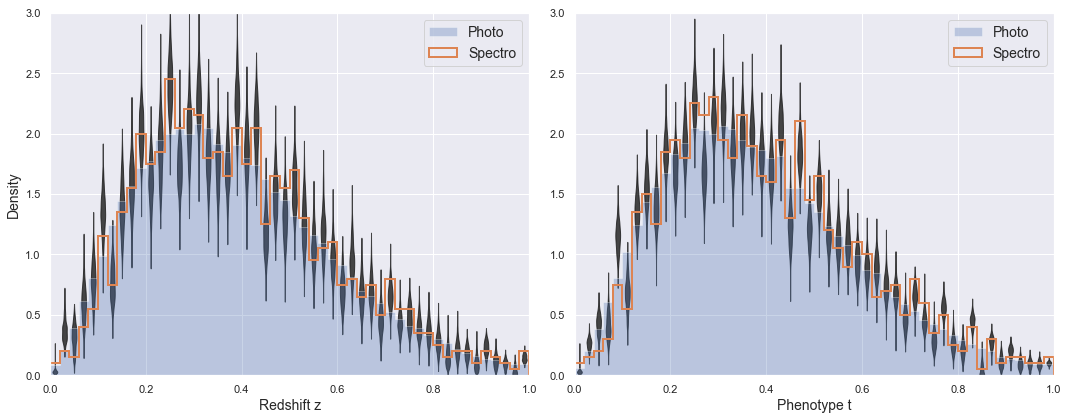

In [46]:
compare_distributions(photo_data, spectro_data, noz.reshape(-1, n_photo))

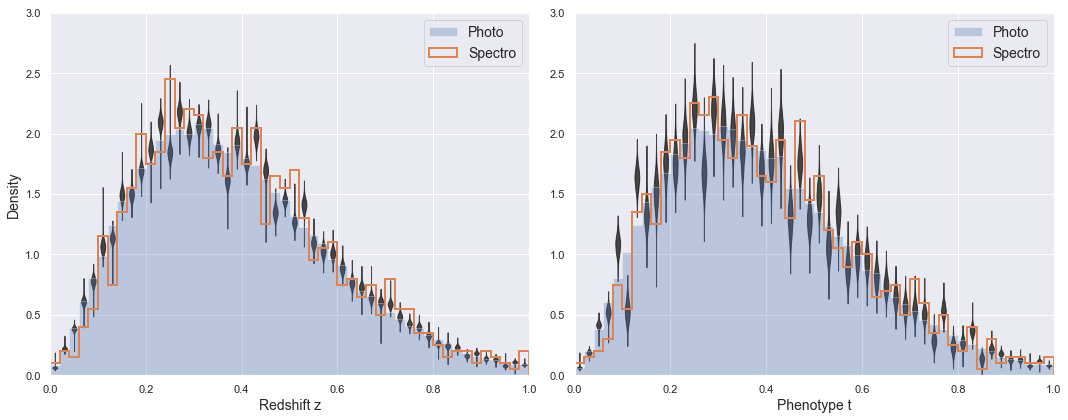

In [47]:
compare_distributions(photo_data, spectro_data, fullz.reshape(-1, n_photo))

Plot the F+delta(z<0.5) part of Figure 6:

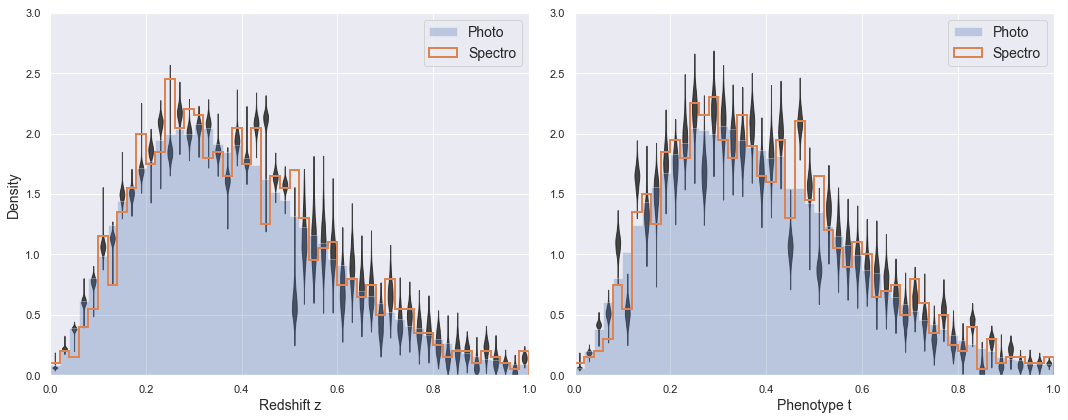

In [48]:
compare_distributions(photo_data, spectro_data, halfz.reshape(-1, n_photo))

Samples drawn only from the prior, without any likelihood, are only slight worse than the F-only plots when displayed like this, but this is deceptive since they have no predictive power for individual galaxies (as shown below):

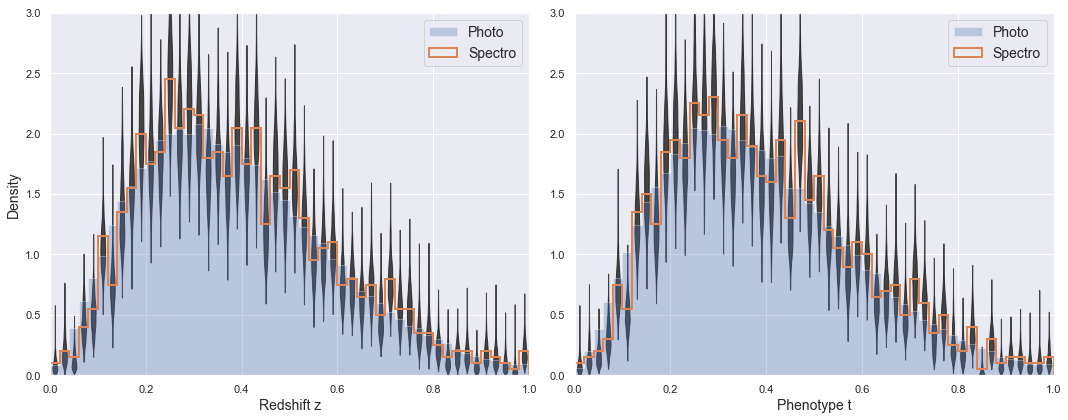

In [49]:
compare_distributions(photo_data, spectro_data, prior.reshape(-1, n_photo))

#### Figure 4

In [50]:
def plot_metric(dz_prior, dz_noz, dz_halfz, dz_fullz):
    bins = np.linspace(-0.008, 0.005, 26)
    plt.hist(dz_prior, bins, histtype='stepfilled', color='orange', ec='none', label='Prior')
    plt.hist(dz_noz, bins, histtype='stepfilled', color='gray', alpha=0.5, ec='none', label='HBM: $F$')
    plt.hist(dz_halfz, bins, histtype='step', color='k', ls='--', label='HBM: $F + \delta(z < 0.5)$')
    plt.hist(dz_fullz, bins, histtype='step', color='r', ls='-', label='HBM: $F + \delta(\mathrm{All} z)$')
    plt.ylabel('Samples')
    plt.grid(False)
    plt.legend(loc='upper left')
    plt.xlim(bins[0], bins[-1])

Combine the 4 chains together:

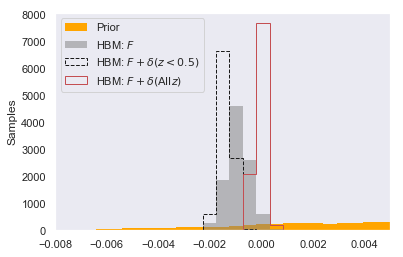

In [51]:
plot_metric(dz_prior.reshape(-1), dz_noz.reshape(-1), dz_halfz.reshape(-1), dz_fullz.reshape(-1))

A plot of each chain individually shows that the offsets in the `noz` and `halfz` results are systematic biases present in each chain, so likely due to the prior being slightly non-representative of the full sample due to a statistical fluctuation.

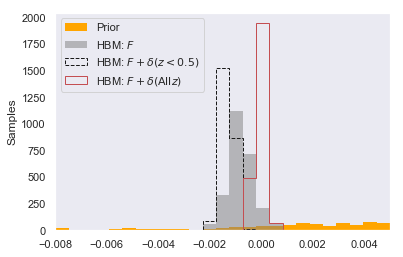

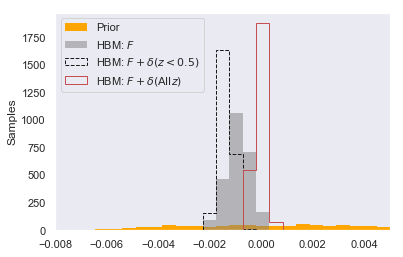

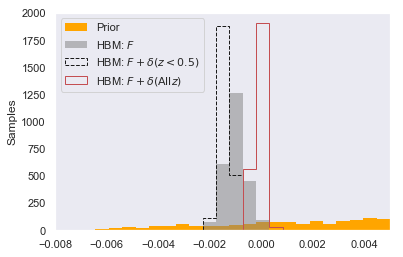

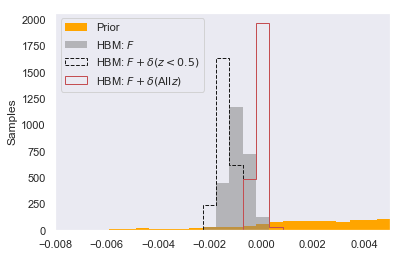

In [52]:
for k in range(4):
    plot_metric(dz_prior[k], dz_noz[k], dz_halfz[k], dz_fullz[k])
    plt.show()

#### Figure 5

In [53]:
def plot_one(idx):
    # Look up this galaxy's true properties.
    galaxy = photo_data[idx]
    F = galaxy['F']
    theta = galaxy['theta_bin']
    t_true = t_mdpt[galaxy['t_bin']]
    z_true = z_mdpt[galaxy['z_bin']]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for label, samples, style in zip(
        ('Prior', '$F_i$', '$F_i + \\delta(\\theta_i)$', '$F_i + \\delta(\\theta_i, z < 0.5)$'),
        (prior, noz, halfz, fullz),
        (dict(histtype='stepfilled', color='orange', ec='none'),
         dict(histtype='stepfilled', color='gray', ec='none', alpha=0.5),
         dict(histtype='step', color='k', ls='--', lw=1),
         dict(histtype='step', color='r', ls='-', lw=2))):
        
        samples = samples.reshape(-1, n_photo)
        
        # Extract (z,t) bin indices for each sample.
        z_bin = unflat_z[samples[:, idx]]
        t_bin = unflat_t[samples[:, idx]]
        # Histogram bin indices.
        z_hist = np.bincount(z_bin, minlength=nz)
        t_hist = np.bincount(t_bin, minlength=nt)
        # Show histograms.
        ax[0].hist(z_mdpt, bins=z_bins, weights=z_hist, label=label, **style)
        ax[1].hist(t_mdpt, bins=t_bins, weights=t_hist, label=label, **style)
        
    ax[0].axvline(z_true, c='b', ls='-', lw=3, alpha=0.5)
    ax[1].axvline(t_true, c='b', ls='-', lw=3, alpha=0.5)
    ax[0].set_xlabel('Redshift')
    ax[1].set_xlabel('Phenotype')
    ax[0].set_ylabel('Samples')
    ax[1].set_ylabel('Samples')
    ax[0].set_xlim(z_bins[0], z_bins[-1])
    ax[1].set_xlim(t_bins[0], t_bins[-1])
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()

Restricting the $1+\delta$ part of the likeihood to  $z<0.5$ has essentially no effect for low-redshift galaxies, but degrades the accuracy to be comparable to $F$-only for high-redshift galaxies.  Note how the prior samples always predict the prior distribution, independent of the individual galaxy properties.

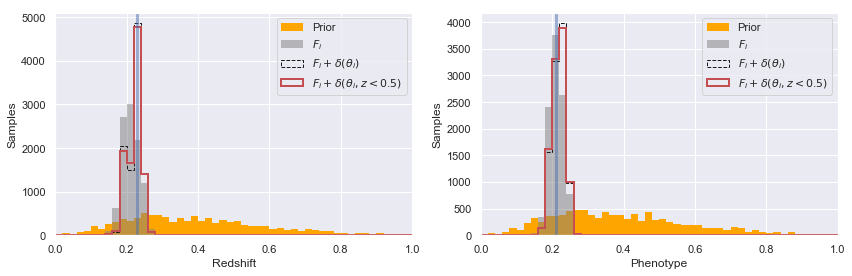

In [54]:
plot_one(0)

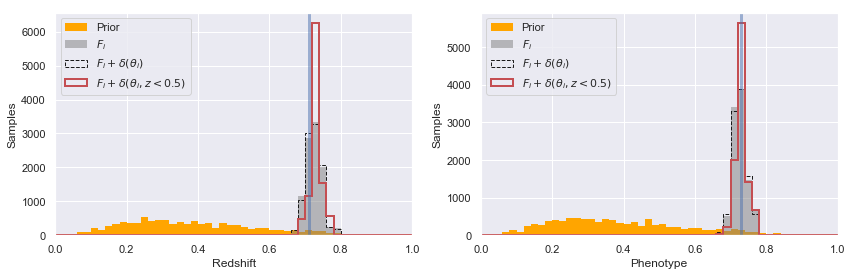

In [55]:
plot_one(8)